# IEEE BigData 2021 RecSys Dataset Wrangling and EDA

## Setup

### Imports

In [29]:
from pathlib import Path
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import os
from os import path as osp
import logging
import sys
from datetime import datetime
from collections import defaultdict
from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

### Data Ingestion

In [2]:
!wget -q --show-progress https://github.com/sparsh-ai/ieee21cup-recsys/raw/main/data/bronze/train.parquet.snappy
!wget -q --show-progress https://github.com/sparsh-ai/ieee21cup-recsys/raw/main/data/bronze/item_info.parquet.snappy
!wget -q --show-progress https://github.com/sparsh-ai/ieee21cup-recsys/raw/main/data/bronze/track1_testset.parquet.snappy
!wget -q --show-progress https://github.com/sparsh-ai/ieee21cup-recsys/raw/main/data/bronze/track2_testset.parquet.snappy

train.parquet.snapp 100%[===================>]  65.26M   163MB/s    in 0.4s    
item_info.parquet.s 100%[===================>]  10.06K  --.-KB/s    in 0s      
track1_testset.parq 100%[===================>]  48.66M   136MB/s    in 0.4s    
track2_testset.parq 100%[===================>]  43.19M   133MB/s    in 0.3s    


### Params

In [2]:
class Args:
    datapath_bronze = '/content'
    datapath_silver = '/content'

    filename_trainset = 'train.parquet.snappy'
    filename_items_metadata = 'df_items_metadata.parquet.snappy'
    filename_items_timestamp = 'df_items_timestamp.parquet.snappy'

In [3]:
args = Args()

### Logging

In [4]:
logging.basicConfig(stream=sys.stdout,
                    level = logging.INFO,
                    format='%(asctime)s [%(levelname)s] : %(message)s',
                    datefmt='%d-%b-%y %H:%M:%S')

logger = logging.getLogger('IEEE21 Logger')

## Utilities

In [16]:
def read_data(name):
    """Read data files from the given path/dataset name"""
    name_path_dict = {
        'trainset': osp.join(args.datapath_bronze,args.filename_trainset),
        'items_ts': osp.join(args.datapath_silver,args.filename_items_timestamp),
        'items_meta': osp.join(args.datapath_silver,args.filename_items_metadata),
    }

    return pd.read_parquet(name_path_dict[name])

In [12]:
def extract_items_timestamp():
    """Extract item id and timestamps in a dataframe"""
    file_savepath = osp.join(args.datapath_silver,args.filename_items_timestamp)

    if not osp.exists(file_savepath):
        logger.info('Extracting Items timestamps')
        df = read_data('trainset')
        item_purchase_history = [history.split(',') for history in df.user_click_history.values]
        item_purchase_history = [item for user_history in item_purchase_history for item in user_history]
        df = pd.DataFrame()
        df[['item_id','timestamp']] = [item.split(':') for item in item_purchase_history]

        df.to_parquet(file_savepath, compression='snappy')
        logger.info('Extraction finished. File saved at {}'.format(file_savepath))
    else:
        logger.info('File already exists at {}'.format(file_savepath))

In [13]:
def extract_items_metadata():
    """Extract item purchase details in a dataframe"""
    file_savepath = osp.join(args.datapath_silver,'df_item_metadata.parquet.snappy')

    if not osp.exists(file_savepath):
        logger.info('Extracting Items metadata')
        df = read_data('items_ts')
        
        item_metadata = []
        with tqdm(total=len(df.item_id.unique())) as pbar:
            for item_id in df.item_id.unique():
                item_timestamps = df[df.item_id == item_id].timestamp
                item_metadata.append({
                    'item_id': item_id,
                    'purchase_total': len(item_timestamps),
                    'purchase_start': item_timestamps.min(),
                    'purchase_end': item_timestamps.max()
                })
                pbar.update()

        df_item_metadata = pd.DataFrame(item_metadata)
        for column in ['purchase_total', 'purchase_start', 'purchase_end']:
            df_item_metadata[column] = pd.to_numeric(df_item_metadata[column])
        df_item_metadata = df_item_metadata.sort_values(by='purchase_start', ascending=True)
        df_item_metadata['purchase_duration'] = df_item_metadata['purchase_end'] - df_item_metadata['purchase_start']
        df_item_metadata.to_parquet(file_savepath, compression='snappy')
        logger.info('Extraction finished. File saved at {}'.format(file_savepath))
    else:
        logger.info('File already exists at {}'.format(file_savepath))

In [30]:
def change_into_datetime(time_int):
    """
    input: 1582992009 (int)
    output: 2020-02-29 16:00:09 (str)
    """
    return datetime.utcfromtimestamp(time_int).strftime('%Y-%m-%d %H:%M:%S')

In [31]:
def change_date_format(df):
    """change datetime into human-readable format"""
    logger.info('Changing datetime format in trainset')
    t = int(df.at[i, 'time'])
    df.at[i, 'datetime'] = change_into_datetime(t)

    # change time in user_click_history into human readable format
    # notice that some user_click_history == '0:0', which means there is no click history for this user
    t = df.at[i, 'user_click_history']
    if t == '0:0':
        df.at[i, 'user_click_history'] = ''
    else:
        new_user_click_history = [sample.split(':')[0] + ':' + change_into_datetime(int(sample.split(':')[1])) for sample in t.split(',')]
        df.at[i, 'user_click_history'] = ','.join(new_user_click_history)
    return df

## Data Loading

In [17]:
df = read_data('trainset')
df.head()

,user_id,user_click_history,user_protrait,exposed_items,labels,time
0,1,"30:1580603130,34:1581178937,15:1581178939,28:1...","64054,21804,80911,36504,8867,7615,54240,37294,...","1,20,28,99,86,119,213,237,164","1,1,1,1,1,1,1,1,1",1582992009
1,2,"20:1580644762,13:1580644765,1:1580644770,127:1...","64054,26565,93755,88510,6344,7615,54240,21927,...","1,4,26,112,86,117,191,234,172","1,1,1,1,1,1,1,1,0",1582992010
2,3,"39:1580772975,6:1580772981,1:1581178309,2:1581...","64054,64086,63021,88510,93500,7615,54240,21927...","22,4,28,48,105,42,193,236,159","1,1,1,0,1,0,0,0,0",1582992014
3,4,"6:1580657608,9:1580657612,15:1580657615,127:15...","64054,21531,6599,16721,37078,7615,54240,65505,...","5,16,1,74,133,122,235,218,172","1,1,1,1,1,1,1,1,0",1582992014
4,5,"37:1580743545,36:1580743554,25:1580743556,37:1...","64054,66036,6599,88510,76066,20543,83978,37294...","6,1,16,85,73,112,239,172,205","1,1,1,1,1,1,1,1,1",1582992017


## Data Processing

In [18]:
logger.info('JOB START: ITEM_TIMESTAMP_EXTRACTION')
extract_items_timestamp()
logger.info('JOB END: ITEM_TIMESTAMP_EXTRACTION')

04-Nov-21 15:24:59 [INFO] : JOB START: ITEM_TIMESTAMP_EXTRACTION
04-Nov-21 15:24:59 [INFO] : Extracting Items timestamps
04-Nov-21 15:25:59 [INFO] : Extraction finished. File saved at /content/df_items_timestamp.parquet.snappy
04-Nov-21 15:26:00 [INFO] : JOB END: ITEM_TIMESTAMP_EXTRACTION


In [8]:
logger.info('JOB START: ITEM_META_EXTRACTION')
extract_items_metadata()
logger.info('JOB END: ITEM_META_EXTRACTION')

04-Nov-21 14:10:38 [INFO] : JOB START: ITEM_META_EXTRACTION
04-Nov-21 14:10:38 [INFO] : Extracting Items metadata


  0%|          | 0/293 [00:00<?, ?it/s]

04-Nov-21 14:15:18 [INFO] : NumExpr defaulting to 2 threads.
04-Nov-21 14:15:18 [INFO] : Extraction finished. File saved at /content/df_item_metadata.parquet.snappy
04-Nov-21 14:15:19 [INFO] : JOB END: ITEM_META_EXTRACTION


In [33]:
logger.info('JOB START: TRAINSET_DATETIME_FORMATING')
df = read_data('trainset')
df_new = change_date_format(df)
logger.info('JOB END: TRAINSET_DATETIME_FORMATING')

## EDA

### Items Sales Chronology

In [19]:
df_items_timestamp = read_data('items_ts')
df_items_timestamp.head()

,item_id,timestamp
0,30,1580603130
1,34,1581178937
2,15,1581178939
3,28,1581178941
4,86,1581178943


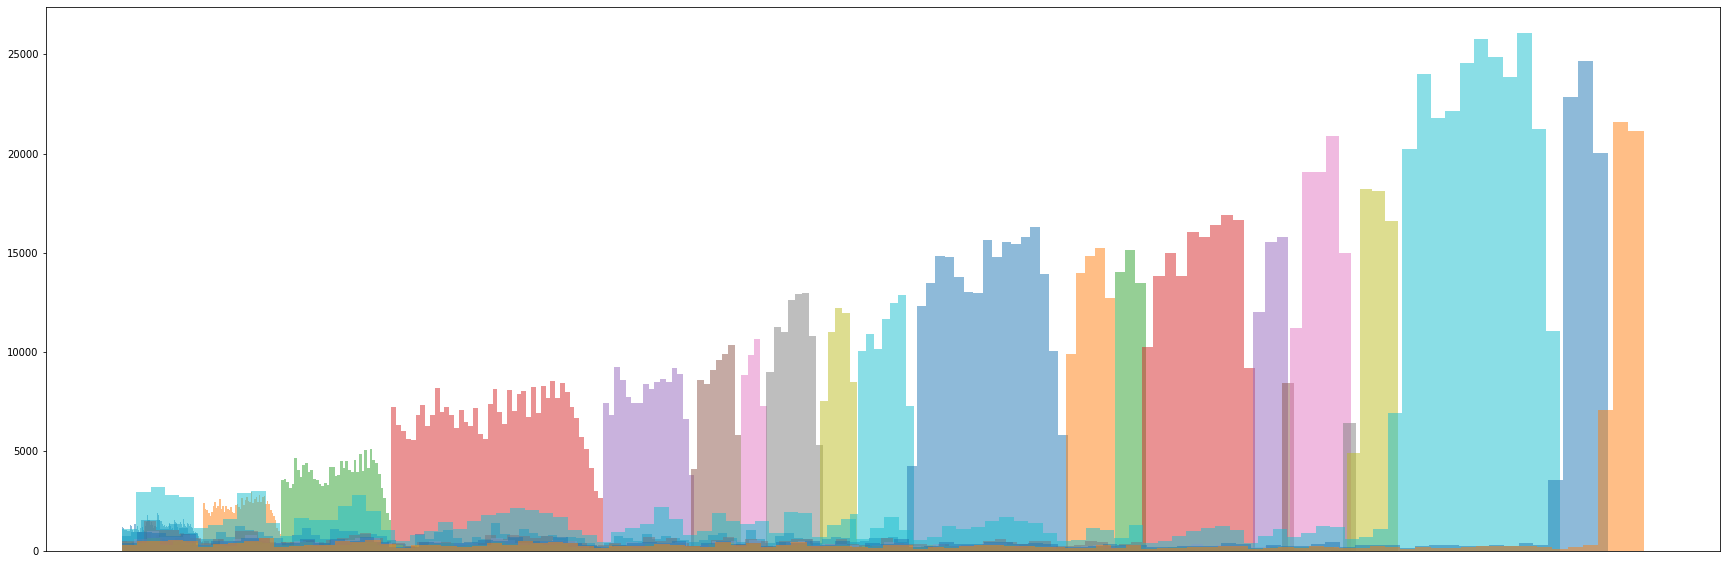

In [22]:
logger.disabled = True
plt.figure(figsize=(30,10))
ax = plt.subplot()
ax.axes.xaxis.set_visible(False)
plt.xticks([])
plt.setp(ax.get_xticklabels(), visible=False)

count = 0
for item_id in df_items_timestamp.item_id.unique():
    if item_id != 0:
        item_timestamps = df_items_timestamp[df_items_timestamp.item_id == item_id].timestamp
        plt.hist(item_timestamps.values, 100, alpha=0.5, label=item_id)
        if count > 20:
            break
        count = count + 1
plt.show()
plt.close()

### Items Sales Durations

In [24]:
df_items_metadata = read_data('items_meta')
df_items_metadata.head()

,item_id,purchase_total,purchase_start,purchase_end,purchase_duration
153,0,28184,0,0,0
9,35,95681,1580572824,1592834594,12261770
71,39,93147,1580572832,1592882484,12309652
1,34,112362,1580572834,1592907029,12334195
19,1,370354,1580572837,1592918933,12346096


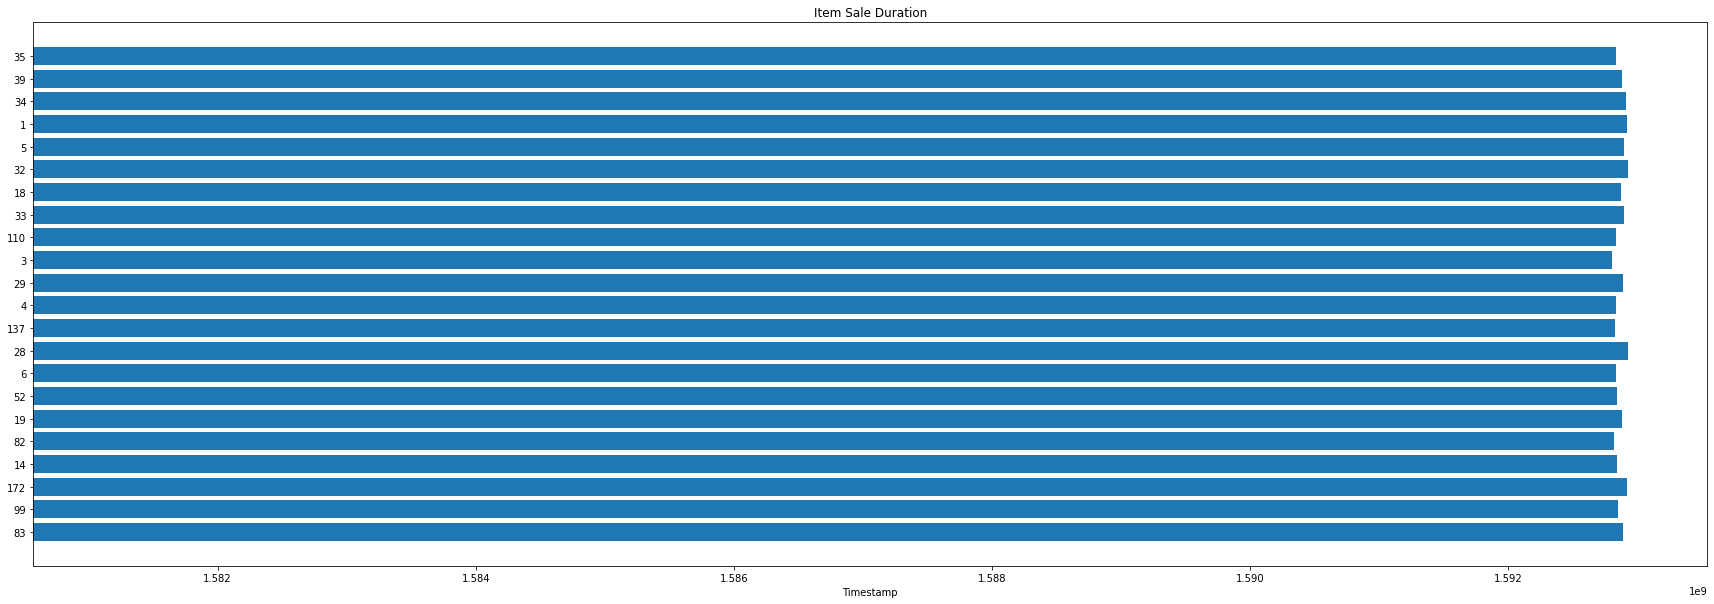

In [25]:
count = 0
x_data = []
x_error = []
y_data = []
for index, item in df_items_metadata.iterrows():
    if item.item_id is not '0':
        y_data.append(item.purchase_end - item.purchase_start)
        x_data.append(item.item_id)
        x_error.append(item.purchase_start)
        if count > 20:
            break
        count = count + 1
y_pos = np.arange(len(x_data))
        
plt.figure(figsize=(30,10))
ax = plt.subplot()

ax.barh(y_pos, y_data, left=x_error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(x_data)
ax.invert_yaxis()
ax.set_xlabel('Timestamp')
ax.set_title('Item Sale Duration')

plt.show()
plt.close()

### Frequency Histograms of Clicked and Purchased Items

In [ ]:
N_ITEMS = 380

clickFreq = [0]*N_ITEMS  # frequency array for clicking
purchFreq = [0]*N_ITEMS  # frequency array for purchase

# read data to pd dataframe
trainSet = read_data('trainset')

  0%|          | 0/260087 [00:00<?, ?it/s]

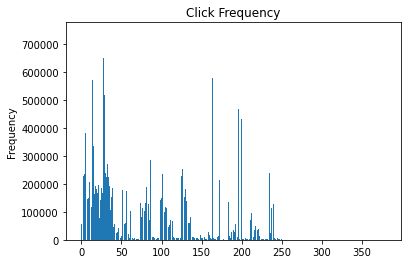

In [27]:
# iterate thru data and parse items clicked
# parse by comma first, then delete everthing after colon
for line in tqdm(trainSet.user_click_history):
    clickSeries = line.split(',')
    itemList = [item.partition(':')[0] for item in clickSeries]
    for item in itemList:
        # increment frequency
        item = int(item)
        clickFreq[item] = clickFreq[item] + 1

# sort the frequency arrays decreasing
# clickFreq.sort(reverse = True)

# draw the two histograms
plt.bar(list(range(N_ITEMS)), clickFreq)
plt.ylabel("Frequency")
plt.title("Click Frequency")
plt.show()

  0%|          | 0/260087 [00:00<?, ?it/s]

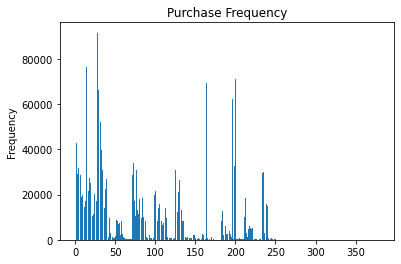

In [28]:
# iterate thru data and parse items purchased
# parse items exposed by comma, then check if purchased in column 'labels'
for r in tqdm(range(trainSet.shape[0])):
    temp = trainSet.exposed_items[r]
    exposedItems = temp.split(',')
    temp = trainSet.labels[r]
    labels = temp.split(',')
    # increment purchase frequency if label==1
    for i in range(len(exposedItems)):
        if int(labels[i])==1:
            purchFreq[int(exposedItems[i])] = purchFreq[int(exposedItems[i])] + 1

# sort the frequency arrays decreasing
# purchFreq.sort(reverse = True)

plt.bar(list(range(N_ITEMS)), purchFreq)
plt.ylabel("Frequency")
plt.title("Purchase Frequency")
plt.show()

### User Click History Analysis

**calculating len of user_click_history**

  0%|          | 0/260087 [00:00<?, ?it/s]

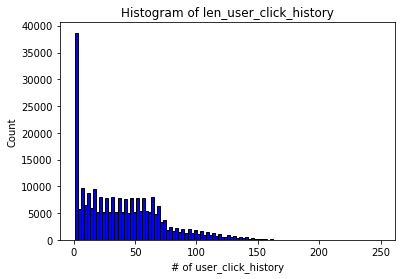

In [34]:
for i in tqdm(range(df_new.shape[0])):
    user_click_history = df_new.at[i, 'user_click_history']
    if user_click_history == '':
        len_user_click_history = 0
    else:
        len_user_click_history = int(len(user_click_history.split(',')))
    df_new.at[i, 'len_user_click_history'] = len_user_click_history

arr = np.array(df_new['len_user_click_history'])
plt.hist(arr, color='blue', edgecolor='black', bins=100)
plt.title('Histogram of len_user_click_history')
plt.xlabel('# of user_click_history')
plt.ylabel('Count')
plt.show()

**what items are users clicking?**

In [38]:
counter = defaultdict(lambda: 0)
for i in tqdm(range(df_new.shape[0])):
    user_click_history = df_new.at[i, 'user_click_history']
    if user_click_history == '':
        continue
    for c in user_click_history.split(','):
        itemid = c.split(':')[0]
        counter[itemid] += 1
counter = dict(counter)
counter_sorted = sorted(counter.items(), key=lambda x: x[1], reverse=True)

  0%|          | 0/260087 [00:00<?, ?it/s]

04-Nov-21 16:17:11 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04-Nov-21 16:17:11 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


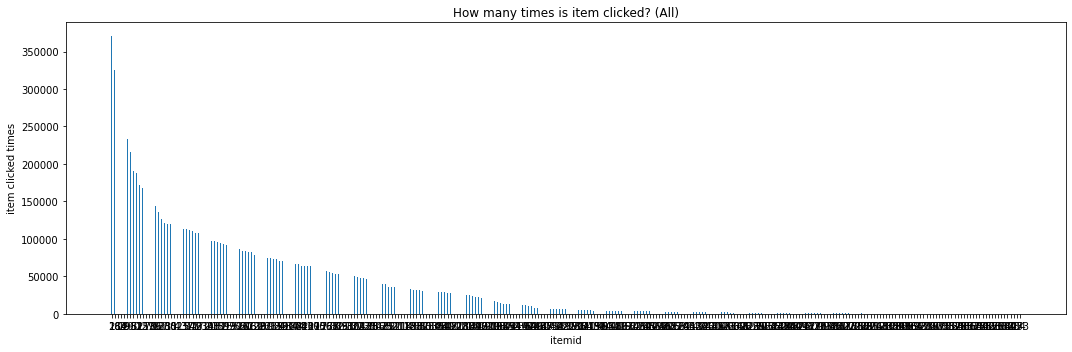

04-Nov-21 16:17:14 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04-Nov-21 16:17:14 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


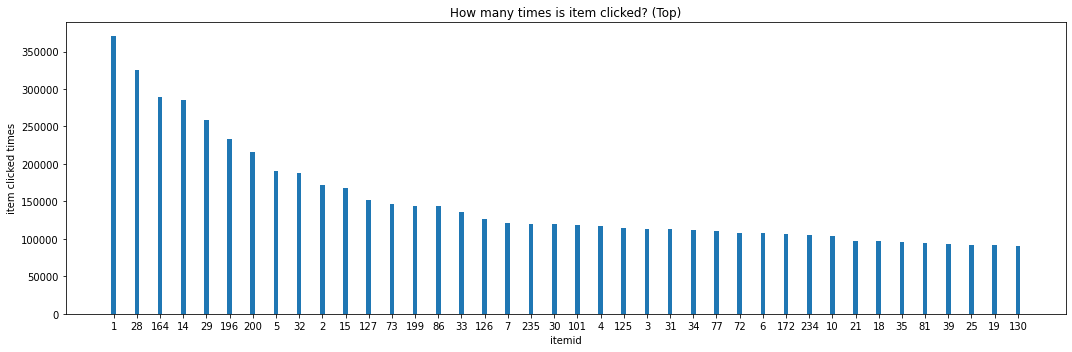

04-Nov-21 16:17:15 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04-Nov-21 16:17:15 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


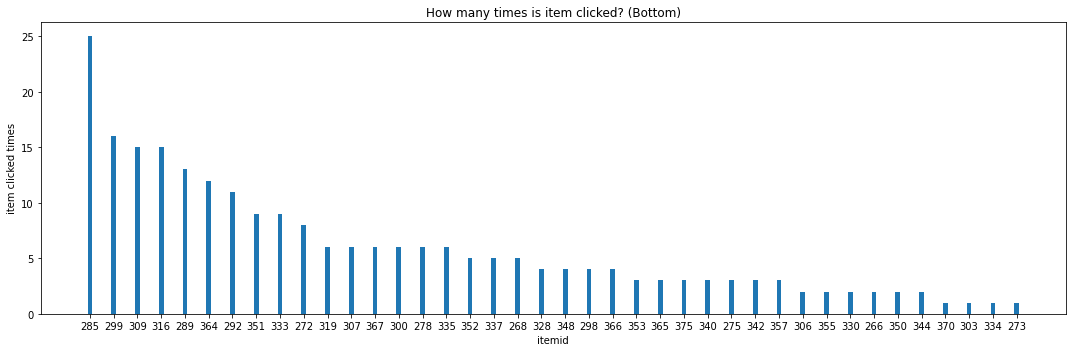

In [39]:
nums_to_plot = counter_sorted
itemids = [n[0] for n in nums_to_plot]
click_cnt = [n[1] for n in nums_to_plot]
plt.figure(figsize=(15, 5))
plt.bar(itemids, click_cnt, width=0.2)
plt.title('How many times is item clicked? (All)')
plt.xlabel('itemid')
plt.ylabel('item clicked times')
plt.tight_layout()
plt.show()


nums_to_plot = counter_sorted[:40]
itemids = [n[0] for n in nums_to_plot]
click_cnt = [n[1] for n in nums_to_plot]
plt.figure(figsize=(15, 5))
plt.bar(itemids, click_cnt, width=0.2)
plt.title('How many times is item clicked? (Top)')
plt.xlabel('itemid')
plt.ylabel('item clicked times')
plt.tight_layout()
plt.show()


nums_to_plot = counter_sorted[-40:]
itemids = [n[0] for n in nums_to_plot]
click_cnt = [n[1] for n in nums_to_plot]
plt.figure(figsize=(15, 5))
plt.bar(itemids, click_cnt, width=0.2)
plt.title('How many times is item clicked? (Bottom)')
plt.xlabel('itemid')
plt.ylabel('item clicked times')
plt.tight_layout()
plt.show()

### Clicks by Session

In [41]:
counter = defaultdict(lambda: 0)
for i in tqdm(range(df_new.shape[0])):
    user_click_history = df_new.at[i, 'user_click_history']
    if user_click_history == '':
        continue
    for c in user_click_history.split(','):
        itemid = c.split(':')[0]
        counter[itemid] += 1
counter = dict(counter)
counter_sorted = sorted(counter.items(), key=lambda x: x[1], reverse=True)

  0%|          | 0/260087 [00:00<?, ?it/s]

04-Nov-21 16:19:14 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04-Nov-21 16:19:15 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


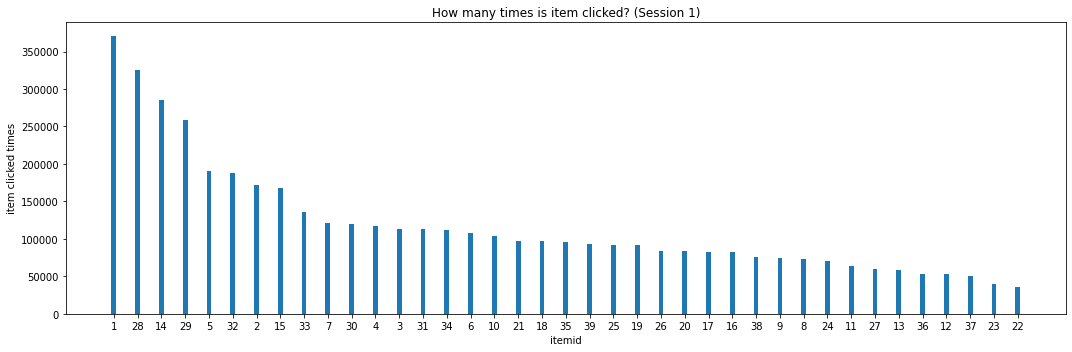

04-Nov-21 16:19:15 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04-Nov-21 16:19:15 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


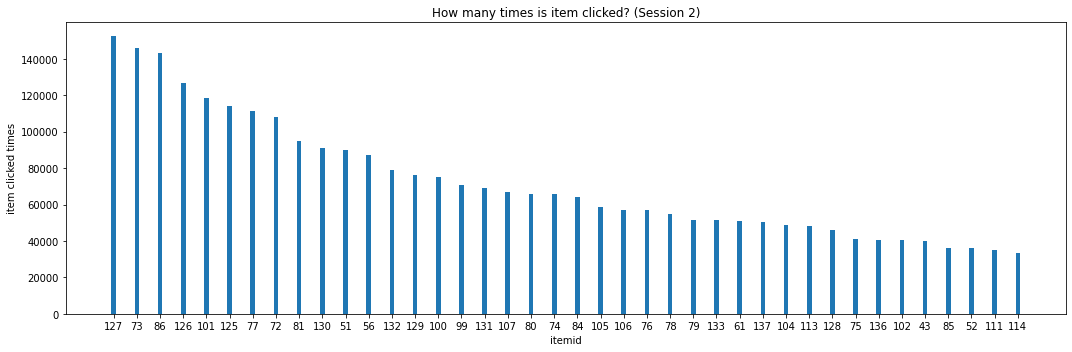

04-Nov-21 16:19:16 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04-Nov-21 16:19:16 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


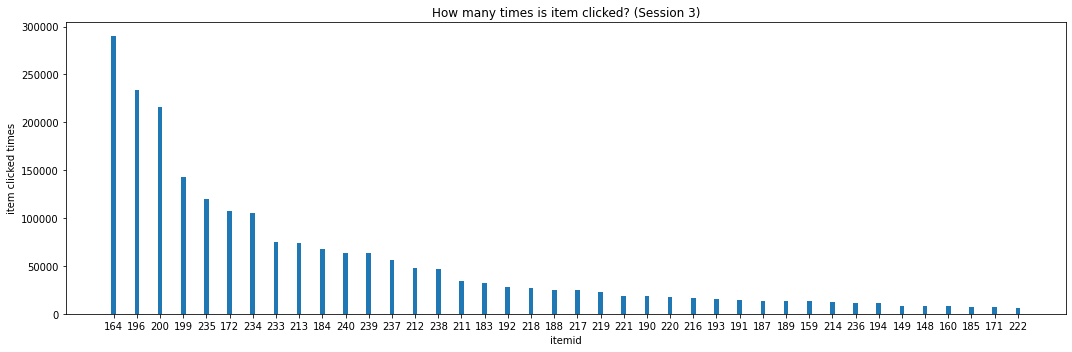

In [42]:
counter_sorted_session1 = [s for s in counter_sorted if 1 <= int(s[0]) <= 39]
counter_sorted_session2 = [s for s in counter_sorted if 40 <= int(s[0]) <= 147]
counter_sorted_session3 = [s for s in counter_sorted if 148 <= int(s[0]) <= 381]

nums_to_plot = counter_sorted_session1
itemids = [n[0] for n in nums_to_plot]
click_cnt = [n[1] for n in nums_to_plot]
plt.figure(figsize=(15, 5))
plt.bar(itemids, click_cnt, width=0.2)
plt.title('How many times is item clicked? (Session 1)')
plt.xlabel('itemid')
plt.ylabel('item clicked times')
plt.tight_layout()
plt.show()

nums_to_plot = counter_sorted_session2[:40]
itemids = [n[0] for n in nums_to_plot]
click_cnt = [n[1] for n in nums_to_plot]
plt.figure(figsize=(15, 5))
plt.bar(itemids, click_cnt, width=0.2)
plt.title('How many times is item clicked? (Session 2)')
plt.xlabel('itemid')
plt.ylabel('item clicked times')
plt.tight_layout()
plt.show()

nums_to_plot = counter_sorted_session3[:40]
itemids = [n[0] for n in nums_to_plot]
click_cnt = [n[1] for n in nums_to_plot]
plt.figure(figsize=(15, 5))
plt.bar(itemids, click_cnt, width=0.2)
plt.title('How many times is item clicked? (Session 3)')
plt.xlabel('itemid')
plt.ylabel('item clicked times')
plt.tight_layout()
plt.show()

### Expose by Session

In [43]:
## expose should only be counted when users are in that session
# s1: 0~2, s2: 3~5, s3: 6~9

counter = defaultdict(lambda: 0)
for i in tqdm(range(df_new.shape[0])):
    user_exposed_history = df_new.at[i, 'exposed_items']
    num_bought = sum([int(l) for l in df_new.at[i, 'labels'].split(',')])
    for idx, itemid in enumerate(user_exposed_history.split(',')):
        if 0 <= idx <= 2:
            counter[itemid] += 1
        elif 3 <= idx <= 5 and num_bought >= 3: 
            counter[itemid] += 1
        elif 6 <= idx <= 8 and num_bought >= 6:
            counter[itemid] += 1
counter = dict(counter)
counter_sorted = sorted(counter.items(), key=lambda x: x[1], reverse=True)

  0%|          | 0/260087 [00:00<?, ?it/s]

04-Nov-21 16:20:59 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04-Nov-21 16:20:59 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


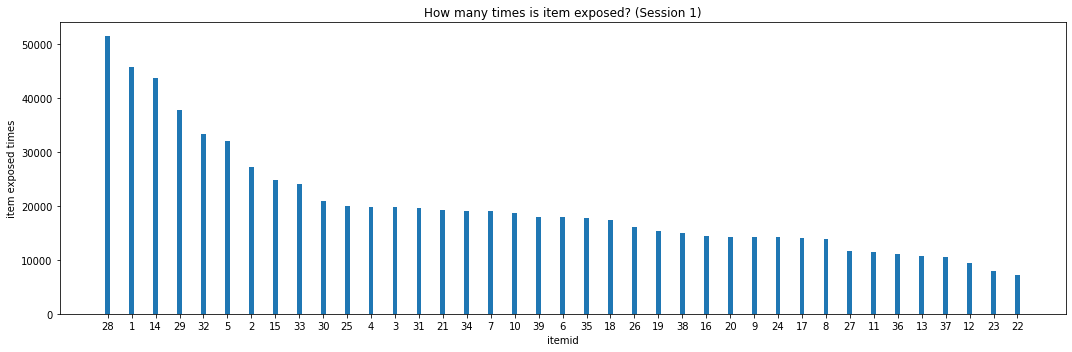

04-Nov-21 16:21:00 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04-Nov-21 16:21:00 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


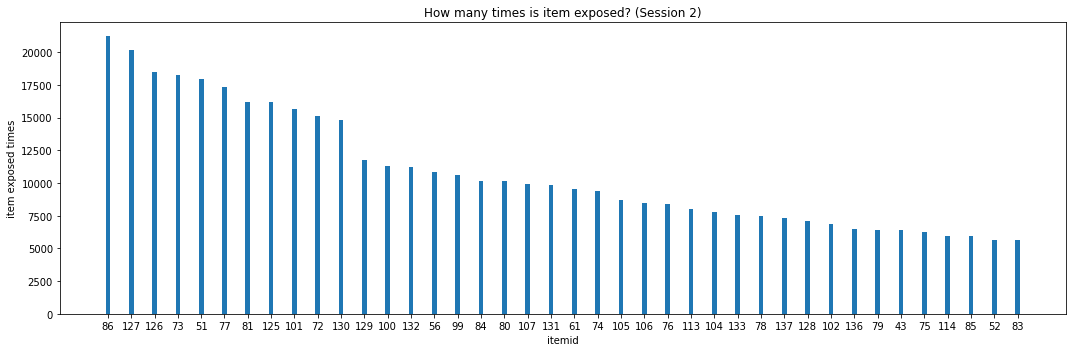

04-Nov-21 16:21:00 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04-Nov-21 16:21:00 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


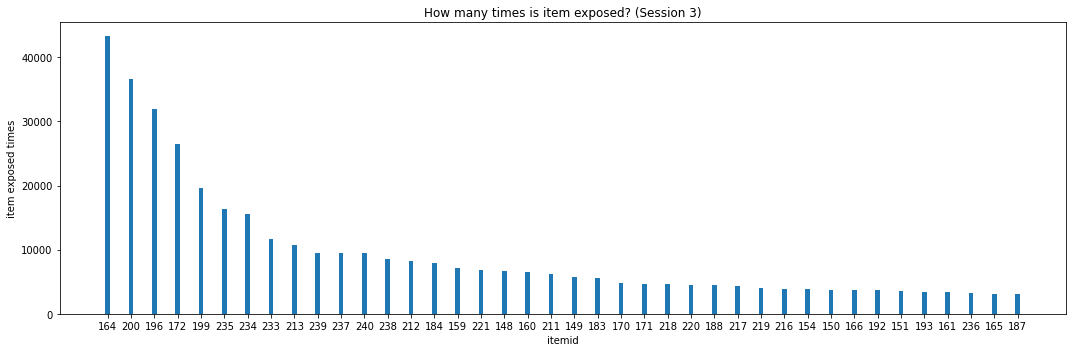

In [44]:
counter_sorted_session1 = [s for s in counter_sorted if 1 <= int(s[0]) <= 39]
counter_sorted_session2 = [s for s in counter_sorted if 40 <= int(s[0]) <= 147]
counter_sorted_session3 = [s for s in counter_sorted if 148 <= int(s[0]) <= 381]

nums_to_plot = counter_sorted_session1
itemids = [n[0] for n in nums_to_plot]
click_cnt = [n[1] for n in nums_to_plot]
plt.figure(figsize=(15, 5))
plt.bar(itemids, click_cnt, width=0.2)
plt.title('How many times is item exposed? (Session 1)')
plt.xlabel('itemid')
plt.ylabel('item exposed times')
plt.tight_layout()
plt.show()

nums_to_plot = counter_sorted_session2[:40]
itemids = [n[0] for n in nums_to_plot]
click_cnt = [n[1] for n in nums_to_plot]
plt.figure(figsize=(15, 5))
plt.bar(itemids, click_cnt, width=0.2)
plt.title('How many times is item exposed? (Session 2)')
plt.xlabel('itemid')
plt.ylabel('item exposed times')
plt.tight_layout()
plt.show()

nums_to_plot = counter_sorted_session3[:40]
itemids = [n[0] for n in nums_to_plot]
click_cnt = [n[1] for n in nums_to_plot]
plt.figure(figsize=(15, 5))
plt.bar(itemids, click_cnt, width=0.2)
plt.title('How many times is item exposed? (Session 3)')
plt.xlabel('itemid')
plt.ylabel('item exposed times')
plt.tight_layout()
plt.show()

### Bought by Session

In [45]:
counter = defaultdict(lambda: 0)
for i in tqdm(range(df_new.shape[0])):
    user_exposed_history = df_new.at[i, 'exposed_items'].split(',')
    labels = df_new.at[i, 'labels'].split(',')
    for idx, itemid in enumerate(user_exposed_history):
        if labels[idx] == '1':
            counter[itemid] += 1
counter = dict(counter)
counter_sorted = sorted(counter.items(), key=lambda x: x[1], reverse=True)

  0%|          | 0/260087 [00:00<?, ?it/s]

04-Nov-21 16:21:43 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04-Nov-21 16:21:43 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


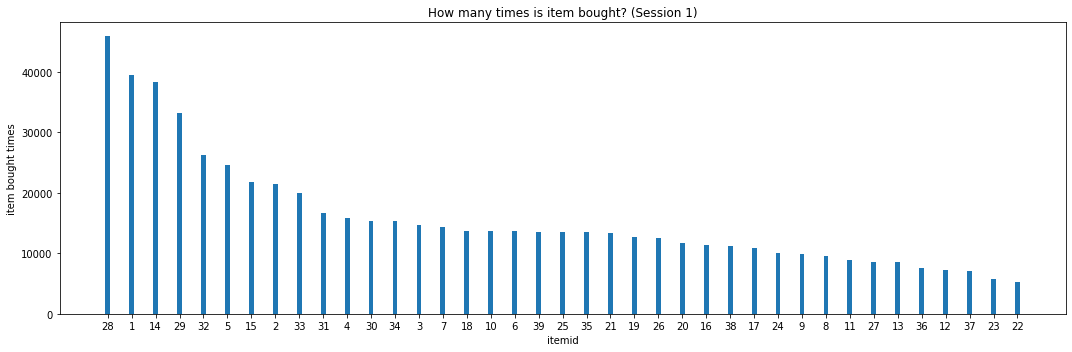

04-Nov-21 16:21:43 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04-Nov-21 16:21:43 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


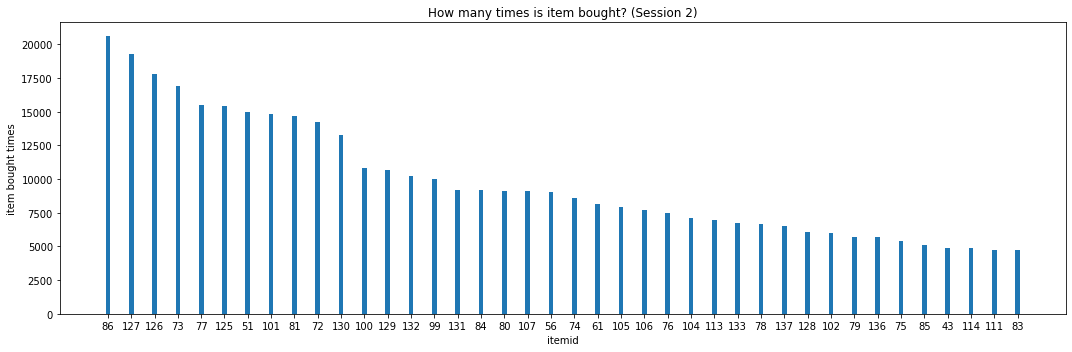

04-Nov-21 16:21:44 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04-Nov-21 16:21:44 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


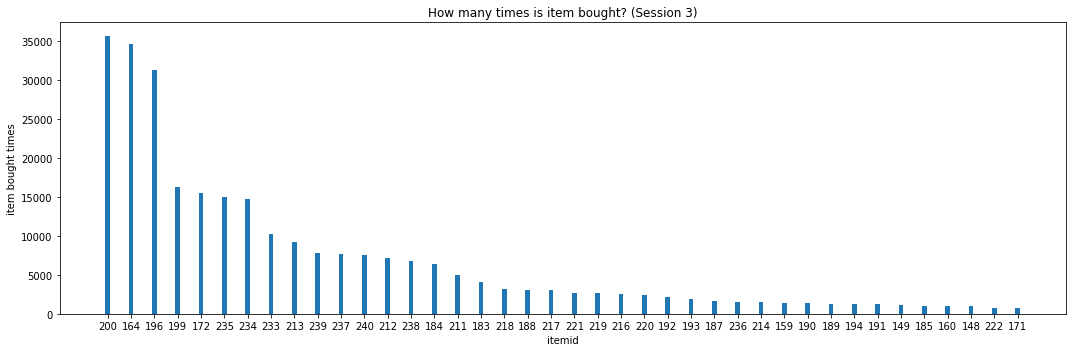

In [46]:
counter_sorted_session1 = [s for s in counter_sorted if 1 <= int(s[0]) <= 39]
counter_sorted_session2 = [s for s in counter_sorted if 40 <= int(s[0]) <= 147]
counter_sorted_session3 = [s for s in counter_sorted if 148 <= int(s[0]) <= 381]

nums_to_plot = counter_sorted_session1
itemids = [n[0] for n in nums_to_plot]
click_cnt = [n[1] for n in nums_to_plot]
plt.figure(figsize=(15, 5))
plt.bar(itemids, click_cnt, width=0.2)
plt.title('How many times is item bought? (Session 1)')
plt.xlabel('itemid')
plt.ylabel('item bought times')
plt.tight_layout()
plt.show()

nums_to_plot = counter_sorted_session2[:40]
itemids = [n[0] for n in nums_to_plot]
click_cnt = [n[1] for n in nums_to_plot]
plt.figure(figsize=(15, 5))
plt.bar(itemids, click_cnt, width=0.2)
plt.title('How many times is item bought? (Session 2)')
plt.xlabel('itemid')
plt.ylabel('item bought times')
plt.tight_layout()
plt.show()

nums_to_plot = counter_sorted_session3[:40]
itemids = [n[0] for n in nums_to_plot]
click_cnt = [n[1] for n in nums_to_plot]
plt.figure(figsize=(15, 5))
plt.bar(itemids, click_cnt, width=0.2)
plt.title('How many times is item bought? (Session 3)')
plt.xlabel('itemid')
plt.ylabel('item bought times')
plt.tight_layout()
plt.show()

### Expose vs Bought

In [47]:
## expose should only be counted when users are in that session
# s1: 0~2, s2: 3~5, s3: 6~9

counter = defaultdict(lambda: [0, 0])
for i in tqdm(range(df_new.shape[0])):
    user_exposed_history = df_new.at[i, 'exposed_items']
    num_bought = sum([int(l) for l in df_new.at[i, 'labels'].split(',')])
    labels = df_new.at[i, 'labels'].split(',')
    for idx, itemid in enumerate(user_exposed_history.split(',')):
        if 0 <= idx <= 2:
            counter[itemid][0] += 1
            if labels[idx] == '1':
                counter[itemid][1] += 1
        elif 3 <= idx <= 5 and num_bought >= 3: 
            counter[itemid][0] += 1
            if labels[idx] == '1':
                counter[itemid][1] += 1
        elif 6 <= idx <= 8 and num_bought >= 6:
            counter[itemid][0] += 1
            if labels[idx] == '1':
                counter[itemid][1] += 1
counter = dict(counter)
counter_sorted = sorted(counter.items(), key=lambda x: x[1][0], reverse=True)

  0%|          | 0/260087 [00:00<?, ?it/s]

04-Nov-21 16:22:26 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04-Nov-21 16:22:26 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


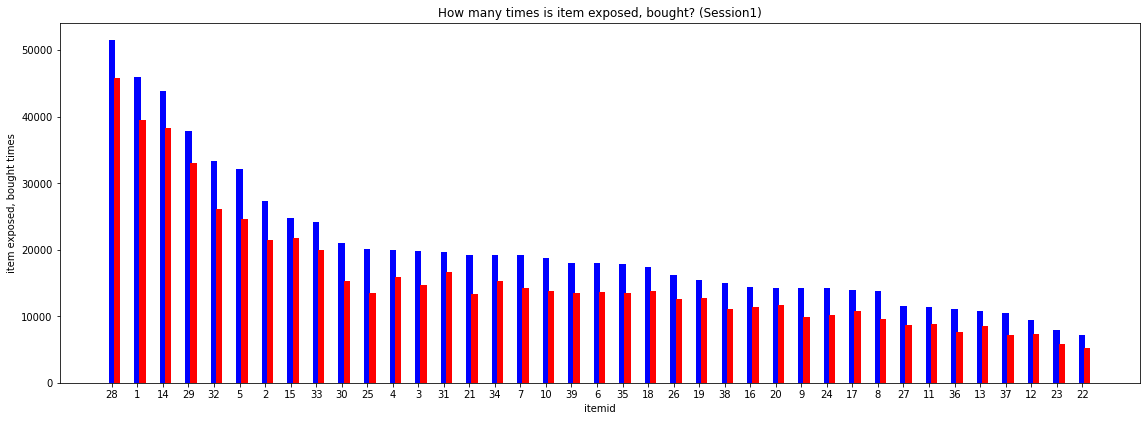

04-Nov-21 16:22:27 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04-Nov-21 16:22:27 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


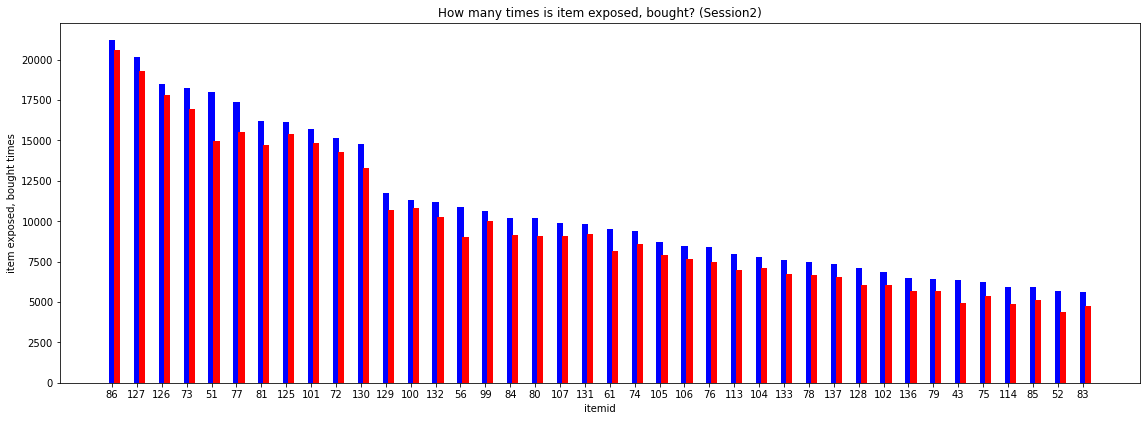

04-Nov-21 16:22:28 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04-Nov-21 16:22:28 [INFO] : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


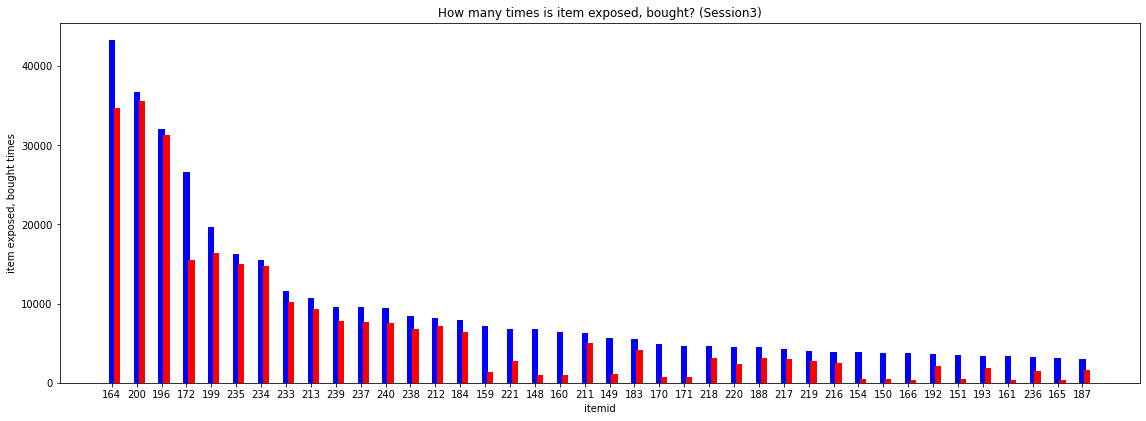

In [48]:
counter_sorted_session1 = [s for s in counter_sorted if 1 <= int(s[0]) <= 39]
counter_sorted_session2 = [s for s in counter_sorted if 40 <= int(s[0]) <= 147]
counter_sorted_session3 = [s for s in counter_sorted if 148 <= int(s[0]) <= 381]

nums_to_plot = counter_sorted_session1[:40]
itemids = [n[0] for n in nums_to_plot]
click_cnt = [n[1][0] for n in nums_to_plot]
bought_cnt = [n[1][1] for n in nums_to_plot]
X = np.arange(len(itemids))
fig = plt.figure(figsize=(15, 5))
plt.bar(itemids, click_cnt, width=0.2)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, click_cnt, color = 'b', width = 0.25)
ax.bar(X + 0.20, bought_cnt, color = 'r', width = 0.25)
plt.xticks(X, itemids)
plt.title('How many times is item exposed, bought? (Session1)')
plt.xlabel('itemid')
plt.ylabel('item exposed, bought times')
plt.show()

nums_to_plot = counter_sorted_session2[:40]
itemids = [n[0] for n in nums_to_plot]
click_cnt = [n[1][0] for n in nums_to_plot]
bought_cnt = [n[1][1] for n in nums_to_plot]
X = np.arange(len(itemids))
fig = plt.figure(figsize=(15, 5))
plt.bar(itemids, click_cnt, width=0.2)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, click_cnt, color = 'b', width = 0.25)
ax.bar(X + 0.20, bought_cnt, color = 'r', width = 0.25)
plt.xticks(X, itemids)
plt.title('How many times is item exposed, bought? (Session2)')
plt.xlabel('itemid')
plt.ylabel('item exposed, bought times')
plt.show()

nums_to_plot = counter_sorted_session3[:40]
itemids = [n[0] for n in nums_to_plot]
click_cnt = [n[1][0] for n in nums_to_plot]
bought_cnt = [n[1][1] for n in nums_to_plot]
X = np.arange(len(itemids))
fig = plt.figure(figsize=(15, 5))
plt.bar(itemids, click_cnt, width=0.2)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, click_cnt, color = 'b', width = 0.25)
ax.bar(X + 0.20, bought_cnt, color = 'r', width = 0.25)
plt.xticks(X, itemids)
plt.title('How many times is item exposed, bought? (Session3)')
plt.xlabel('itemid')
plt.ylabel('item exposed, bought times')
plt.show()

### Expose vs Bought by Session

In [49]:
## expose should only be counted when users are in that session
# s1: 0~2, s2: 3~5, s3: 6~9

counter = defaultdict(lambda: [0, 0, 0])
for i in tqdm(range(df_new.shape[0])):
    user_exposed_history = df_new.at[i, 'exposed_items']
    num_bought = sum([int(l) for l in df_new.at[i, 'labels'].split(',')])
    labels = df_new.at[i, 'labels'].split(',')
    for idx, itemid in enumerate(user_exposed_history.split(',')):
        if 0 <= idx <= 2:
            counter[itemid][0] += 1
            if labels[idx] == '1':
                counter[itemid][1] += 1
        elif 3 <= idx <= 5 and num_bought >= 3: 
            counter[itemid][0] += 1
            if labels[idx] == '1':
                counter[itemid][1] += 1
        elif 6 <= idx <= 8 and num_bought >= 6:
            counter[itemid][0] += 1
            if labels[idx] == '1':
                counter[itemid][1] += 1
counter = dict(counter)
for k, v in counter.items():
    counter[k][2] = counter[k][1] / counter[k][0]
counter_sorted = sorted(counter.items(), key=lambda x: x[1][2], reverse=True)

counter_sorted_session1 = [s for s in counter_sorted if 1 <= int(s[0]) <= 39]
counter_sorted_session2 = [s for s in counter_sorted if 40 <= int(s[0]) <= 147]
counter_sorted_session3 = [s for s in counter_sorted if 148 <= int(s[0]) <= 381]

  0%|          | 0/260087 [00:00<?, ?it/s]

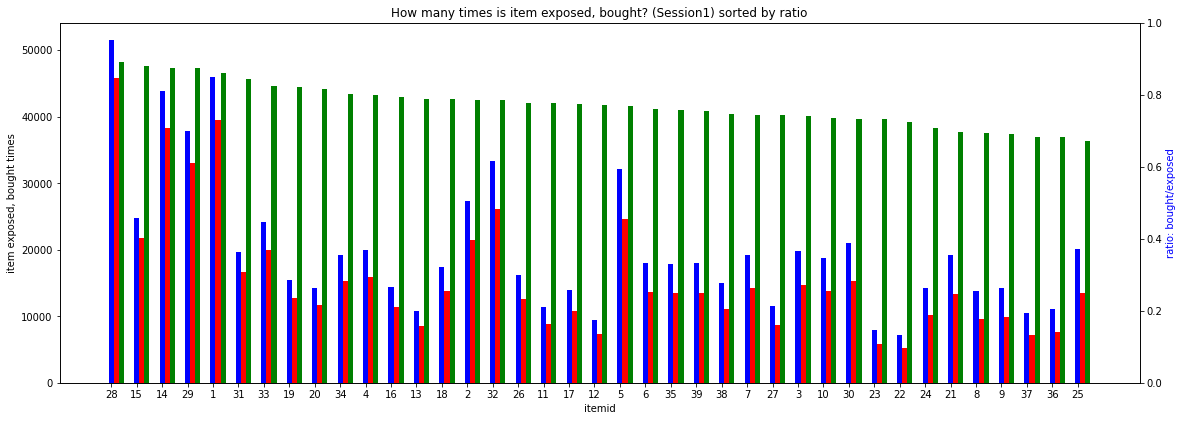

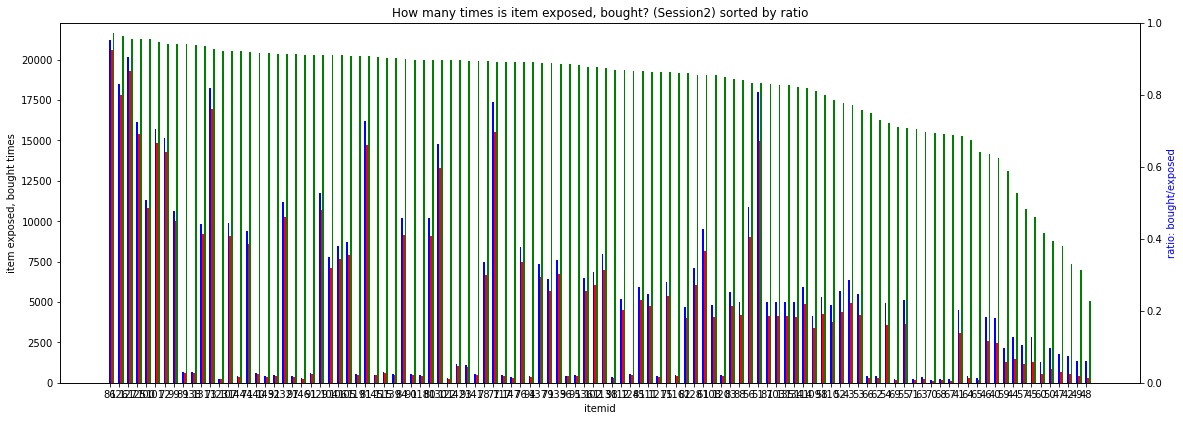

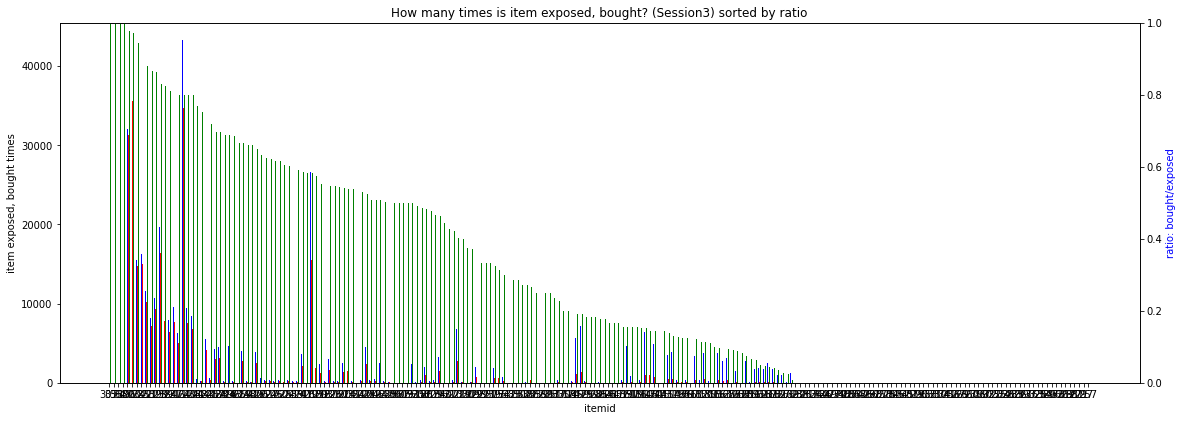

In [51]:
nums_to_plot = counter_sorted_session1
itemids = [n[0] for n in nums_to_plot]
expose_cnt = [n[1][0] for n in nums_to_plot]
bought_cnt = [n[1][1] for n in nums_to_plot]
bought_expose_ratio = [n[1][2] for n in nums_to_plot]
X = np.arange(len(itemids))
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, expose_cnt, color = 'b', width = 0.2)
ax.bar(X + 0.20, bought_cnt, color = 'r', width = 0.2)
plt.xticks(X, itemids)
plt.title('How many times is item exposed, bought? (Session1) sorted by ratio')
plt.xlabel('itemid')
plt.ylabel('item exposed, bought times')
ax2 = ax.twinx()
ax2.bar(X + 0.40, bought_expose_ratio, color = 'g', width = 0.2)
ax2.set_ylim([0, 1])
ax2.set_ylabel('ratio: bought/exposed', color='b')
# plt.yscale('log')
plt.show()


nums_to_plot = counter_sorted_session2
itemids = [n[0] for n in nums_to_plot]
expose_cnt = [n[1][0] for n in nums_to_plot]
bought_cnt = [n[1][1] for n in nums_to_plot]
bought_expose_ratio = [n[1][2] for n in nums_to_plot]
X = np.arange(len(itemids))
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, expose_cnt, color = 'b', width = 0.2)
ax.bar(X + 0.20, bought_cnt, color = 'r', width = 0.2)
plt.xticks(X, itemids)
plt.title('How many times is item exposed, bought? (Session2) sorted by ratio')
plt.xlabel('itemid')
plt.ylabel('item exposed, bought times')
ax2 = ax.twinx()
ax2.bar(X + 0.40, bought_expose_ratio, color = 'g', width = 0.2)
ax2.set_ylim([0, 1])
ax2.set_ylabel('ratio: bought/exposed', color='b')
# plt.yscale('log')
plt.show()


nums_to_plot = counter_sorted_session3
itemids = [n[0] for n in nums_to_plot]
expose_cnt = [n[1][0] for n in nums_to_plot]
bought_cnt = [n[1][1] for n in nums_to_plot]
bought_expose_ratio = [n[1][2] for n in nums_to_plot]
X = np.arange(len(itemids))
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, expose_cnt, color = 'b', width = 0.2)
ax.bar(X + 0.20, bought_cnt, color = 'r', width = 0.2)
plt.xticks(X, itemids)
plt.title('How many times is item exposed, bought? (Session3) sorted by ratio')
plt.xlabel('itemid')
plt.ylabel('item exposed, bought times')
# plt.yscale('log')
ax2 = ax.twinx()
ax2.bar(X + 0.40, bought_expose_ratio, color = 'g', width = 0.2)
ax2.set_ylim([0, 1])
ax2.set_ylabel('ratio: bought/exposed', color='b')
plt.show()

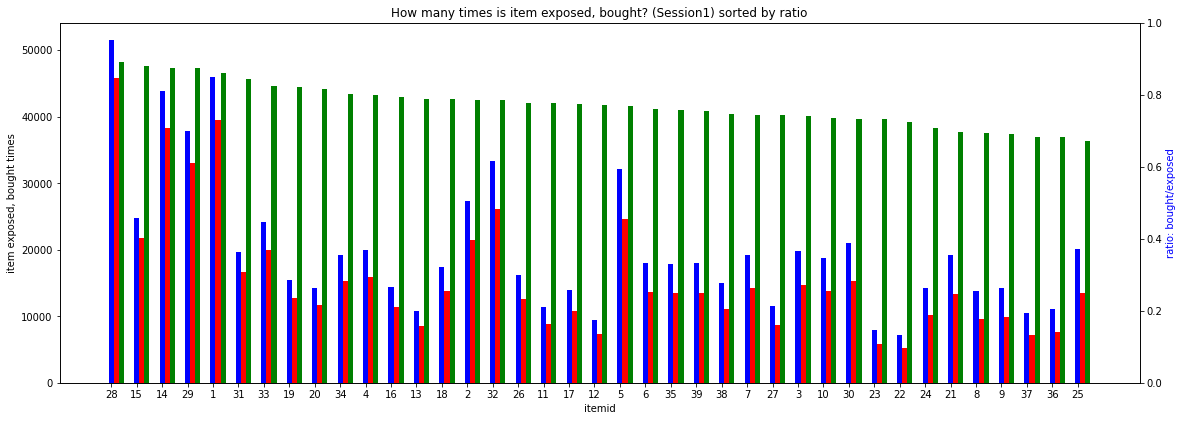

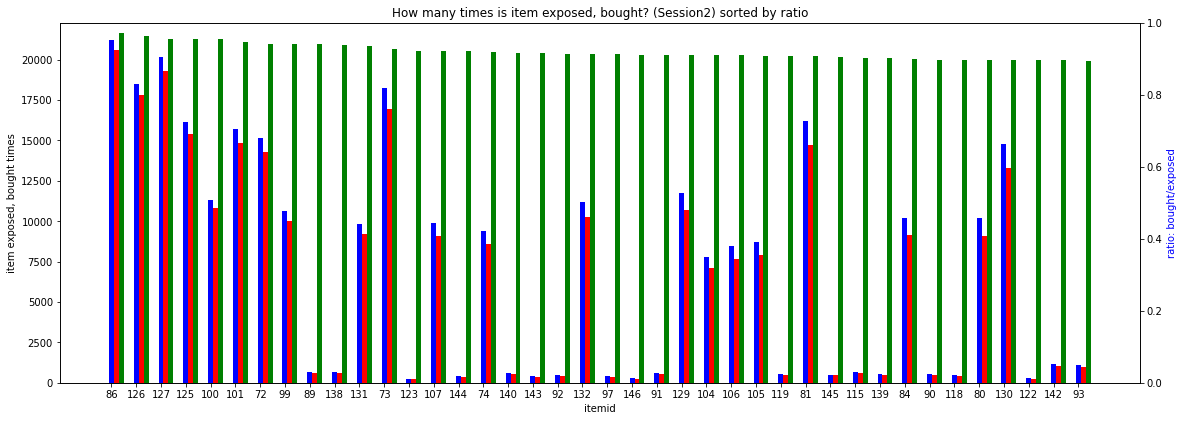

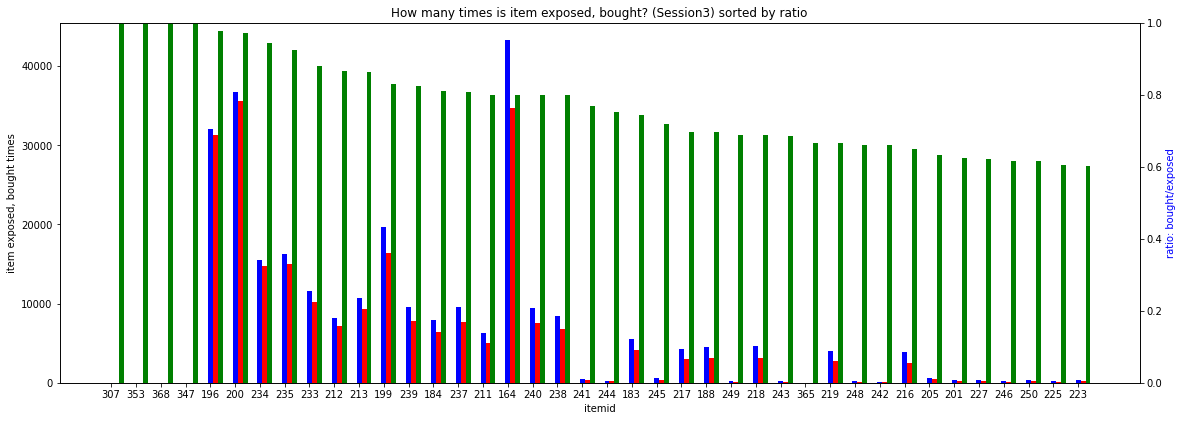

In [53]:
nums_to_plot = counter_sorted_session1[:40]
itemids = [n[0] for n in nums_to_plot]
expose_cnt = [n[1][0] for n in nums_to_plot]
bought_cnt = [n[1][1] for n in nums_to_plot]
bought_expose_ratio = [n[1][2] for n in nums_to_plot]
X = np.arange(len(itemids))
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, expose_cnt, color = 'b', width = 0.2)
ax.bar(X + 0.20, bought_cnt, color = 'r', width = 0.2)
plt.xticks(X, itemids)
plt.title('How many times is item exposed, bought? (Session1) sorted by ratio')
plt.xlabel('itemid')
plt.ylabel('item exposed, bought times')
ax2 = ax.twinx()
ax2.bar(X + 0.40, bought_expose_ratio, color = 'g', width = 0.2)
ax2.set_ylim([0, 1])
ax2.set_ylabel('ratio: bought/exposed', color='b')
# plt.yscale('log')
plt.show()


nums_to_plot = counter_sorted_session2[:40]
itemids = [n[0] for n in nums_to_plot]
expose_cnt = [n[1][0] for n in nums_to_plot]
bought_cnt = [n[1][1] for n in nums_to_plot]
bought_expose_ratio = [n[1][2] for n in nums_to_plot]
X = np.arange(len(itemids))
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, expose_cnt, color = 'b', width = 0.2)
ax.bar(X + 0.20, bought_cnt, color = 'r', width = 0.2)
plt.xticks(X, itemids)
plt.title('How many times is item exposed, bought? (Session2) sorted by ratio')
plt.xlabel('itemid')
plt.ylabel('item exposed, bought times')
ax2 = ax.twinx()
ax2.bar(X + 0.40, bought_expose_ratio, color = 'g', width = 0.2)
ax2.set_ylim([0, 1])
ax2.set_ylabel('ratio: bought/exposed', color='b')
# plt.yscale('log')
plt.show()


nums_to_plot = counter_sorted_session3[:40]
itemids = [n[0] for n in nums_to_plot]
expose_cnt = [n[1][0] for n in nums_to_plot]
bought_cnt = [n[1][1] for n in nums_to_plot]
bought_expose_ratio = [n[1][2] for n in nums_to_plot]
X = np.arange(len(itemids))
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, expose_cnt, color = 'b', width = 0.2)
ax.bar(X + 0.20, bought_cnt, color = 'r', width = 0.2)
plt.xticks(X, itemids)
plt.title('How many times is item exposed, bought? (Session3) sorted by ratio')
plt.xlabel('itemid')
plt.ylabel('item exposed, bought times')
ax2 = ax.twinx()
ax2.bar(X + 0.40, bought_expose_ratio, color = 'g', width = 0.2)
ax2.set_ylim([0, 1])
ax2.set_ylabel('ratio: bought/exposed', color='b')
# plt.yscale('log')
plt.show()

### Label Analysis

  0%|          | 0/260087 [00:00<?, ?it/s]

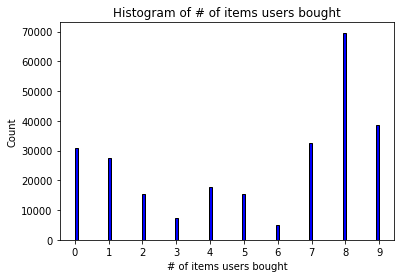

In [55]:
for i in tqdm(range(df_new.shape[0])):
    labels = df_new.at[i, 'labels'].split(',')
    df_new.at[i, 'cnt_labels'] = sum([int(l) for l in labels])

arr = np.array(df_new['cnt_labels'])
plt.hist(arr, color='blue', edgecolor='black', bins=100)
plt.title('Histogram of # of items users bought')
plt.xticks(range(10), range(10))
plt.xlabel('# of items users bought')
plt.ylabel('Count')
plt.show()

In [56]:
arr = np.array(df_new['cnt_labels'])
for i in range(10):
    print('There are', len(arr[arr == i]), 'users have bout', i, 'items')

There are 30912 users have bout 0 items
There are 27620 users have bout 1 items
There are 15330 users have bout 2 items
There are 7317 users have bout 3 items
There are 17895 users have bout 4 items
There are 15486 users have bout 5 items
There are 4810 users have bout 6 items
There are 32512 users have bout 7 items
There are 69645 users have bout 8 items
There are 38560 users have bout 9 items
